# Initial Steps

## Install Dependencies

In [ ]:
# !pip install openai
# !python -m pip install python-dotenv
# !pip install readline
# !pip install panel
# !pip install --upgrade langchain
# !pip install pypdf
# !pip install yt-dlp -U
# !pip install pydub
# !pip install tiktoken
# !pip install chromadb

# !pip install unstructured
# !pip install python-pptx
# !pip install chromadb
!pip uninstall pydantic typing_extensions

Found existing installation: pydantic 1.10.5
Uninstalling pydantic-1.10.5:
  Would remove:
    /home/younis/.local/lib/python3.10/site-packages/pydantic-1.10.5.dist-info/*
    /home/younis/.local/lib/python3.10/site-packages/pydantic/*
Proceed (Y/n)? 

## Setup

In [33]:
import json
with open("../config.json") as f:
    config = json.load(f)

## Introduction

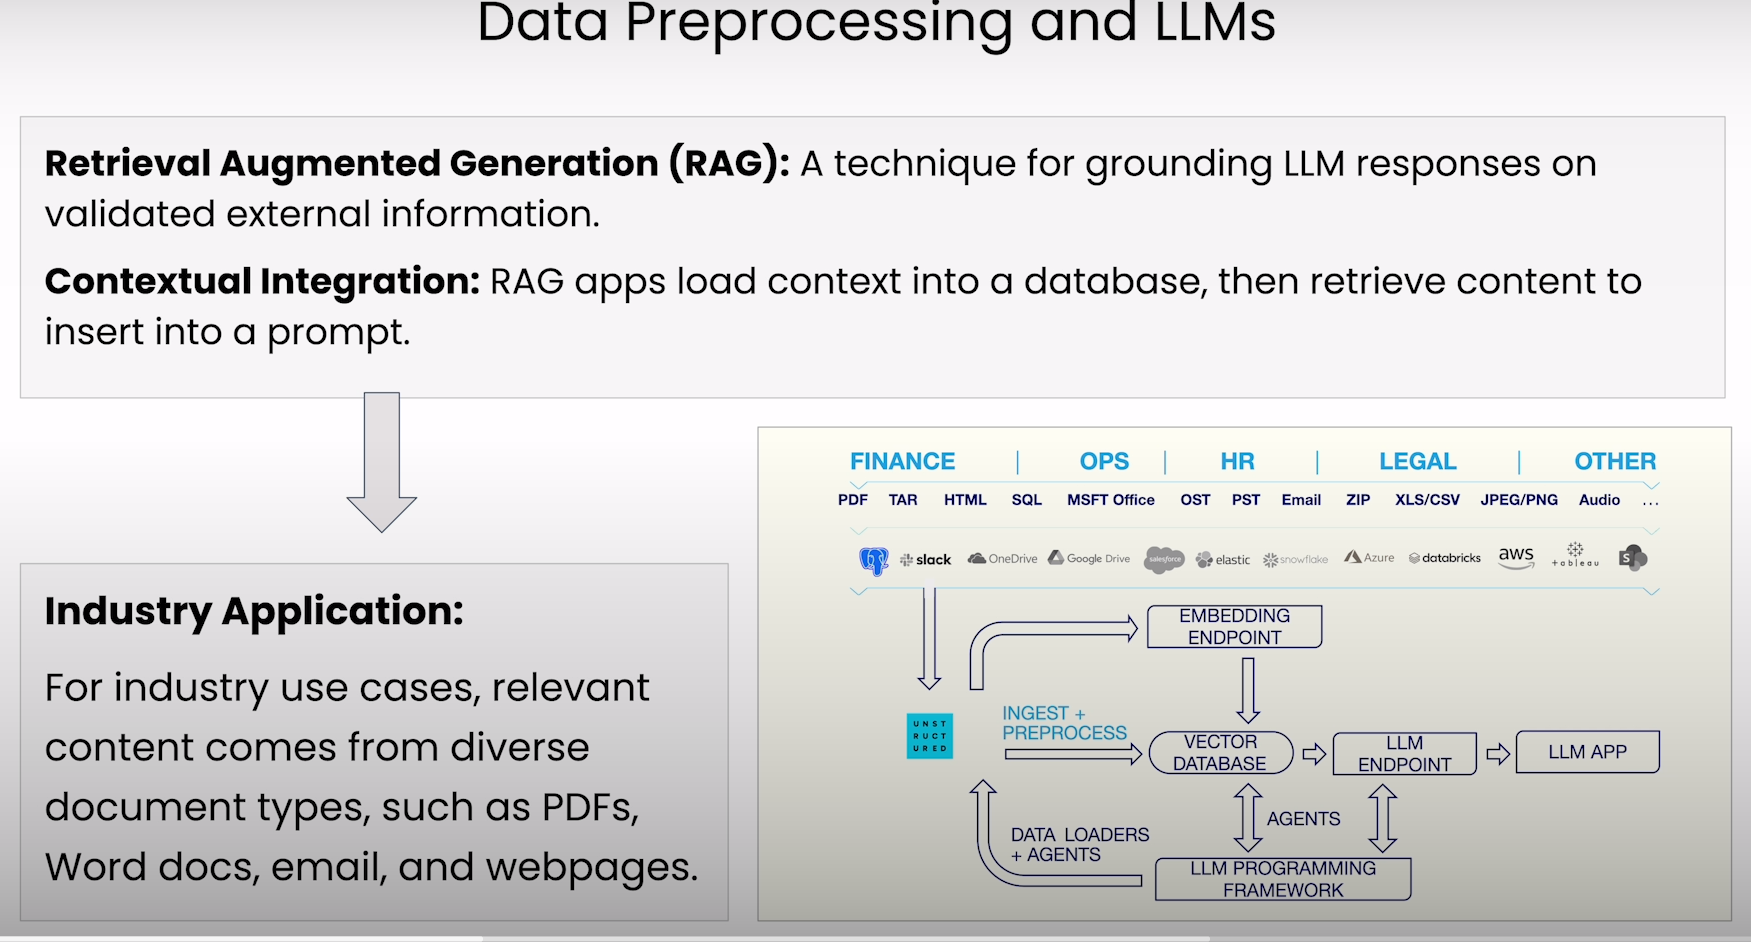

## Normalizing the content

* Normalizing diverse documents
  - Documents may come from variety of formats.
  - The first step in preprocessing is to convert to the comman format of raw documents that identifies comman document elements
  - once the normalization is complete next step is Data Serialization allows results of document preprocessing to be used again later.
  - we serialize our data as json
* Data Serialization
   - allows the preprocessed documents to be used again later.
   - JSON will be good choice because of the following reasons
     - standard of HTTP
     - structure is common and well understood
     - able to use in multiple programming languages
     - can be converted to JSONL for streaming use cases
* PDF use case
  - pdfs have complex layout and tables
  - pdfs maintains consistent formatting across devices
  - complex structures with diverse layouts
  - while extraction, preserving context and layout, distinguish between main text, headers, footers, and side notes

https://docs.unstructured.io/open-source/introduction/quick-start

In [1]:
from unstructured_client import UnstructuredClient
from unstructured_client.models import shared
from unstructured_client.models.errors import SDKError

from unstructured.chunking.title import chunk_by_title
from unstructured.partition.md import partition_md
from unstructured.partition.pptx import partition_pptx
from unstructured.staging.base import dict_to_elements

import chromadb

In [3]:
# Setup the unstructured client
s = UnstructuredClient(
    api_key_auth=config['unstructured_api_key'],
    server_url=config[
)

## Process PDF

In [17]:
# process sample pdf and get data from there
filename = "sample_data/jeff103.pdf"
with open(filename, "rb") as f:
    files=shared.Files(
        content=f.read(), 
        file_name=filename,
    )

req = shared.PartitionParameters(
    files=files,
    strategy='hi_res',
    pdf_infer_table_structure=True,
    languages=["eng"],
)
try:
    resp = s.general.partition(req)
    print(json.dumps(resp.elements[:3], indent=2))
except SDKError as e:
    print(e)

[
  {
    "type": "Image",
    "element_id": "8f8c9408538d496f45a9d33f0a42b125",
    "text": "/) Toe Stosies aboul ) Flying I. His First Flight Liam O Flallerly II. Black Aeroplane Frederick Forsylll",
    "metadata": {
      "filetype": "application/pdf",
      "languages": [
        "eng"
      ],
      "page_number": 1,
      "filename": "jeff103.pdf"
    }
  },
  {
    "type": "Image",
    "element_id": "7f2c73f465bb57c40540dbd44fa0170b",
    "text": "BEFORE  YOU  READ Since the earliest times, humans have dreamt of conquering the skies. Here are two stories about flying.  I. A young seagull is afraid to fly. How does he conquer his fear?  II. A pilot is lost in storm clouds. Does he arrive safe? Who helps  him?  I His  First  Flight  THE  young  seagull  was  alone  on  his  ledge.  His  two brothers  and  his  sister  had  already  flown  away  the day  before.  He  had  been  afraid  to  fly  with  them. Somehow when he had taken a little run forward to the  brink  of  the  ledg

In [16]:
JSON(json.dumps(resp.elements, indent=2))
print("Dumped to json")

Dumped to json


## Metadata extraction, chunking , and RAG Bot

* What is metadata
  - additional document details
  - source information like url, path etc.
  - enables search enhancement in RAG systems
* what is semantic search for LLMs
  - Goal: given an input find semantically similar content from a corpus of documents for use in prompt templates.
  - Prompt templating: insert relevant content into a template to generate prompt template for the LLM.

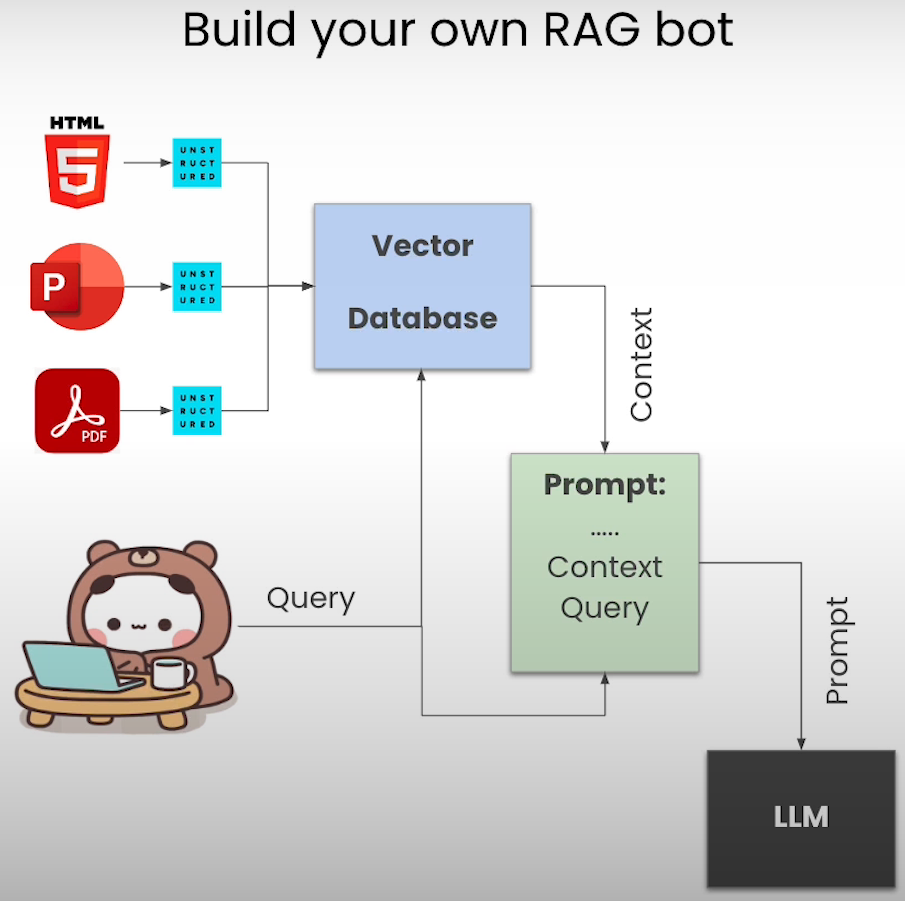

### Process pds and get pdf elements

In [12]:
# processing pdf
filename = "sample_data/research_paper.pdf"

with open(filename, "rb") as f:
    files=shared.Files(
        content=f.read(),
        file_name=filename,
    )

req = shared.PartitionParameters(
    files=files,
    strategy="hi_res",
    hi_res_model_name="yolox",
    pdf_infer_table_structure=True,
    skip_infer_table_types=[],
)

try:
    resp = s.general.partition(req)
    pdf_elements = dict_to_elements(resp.elements)
except SDKError as e:
    print(e)

In [13]:
pdf_elements[0].to_dict()

{'type': 'Title',
 'element_id': '64b04b1edcc00a2f63197c14858ffe64',
 'text': 'OCR-free Document Understanding Transformer',
 'metadata': {'filetype': 'application/pdf',
  'languages': ['eng'],
  'page_number': 1,
  'filename': 'research_paper.pdf'}}

In [16]:
tables = [el for el in pdf_elements if el.category == "Table"]

In [15]:
tables

In [17]:
table_html = tables[0].metadata.text_as_html

In [18]:
from io import StringIO 
from lxml import etree

parser = etree.XMLParser(remove_blank_text=True)
file_obj = StringIO(table_html)
tree = etree.parse(file_obj, parser)
print(etree.tostring(tree, pretty_print=True).decode())

<table>
  <tr>
    <td>NAVER CLOVA</td>
    <td>2NAVER Search</td>
    <td>3SNAVER AI Lal</td>
  </tr>
</table>



In [19]:
reference_title = [
    el for el in pdf_elements
    if el.text == "References"
    and el.category == "Title"
][0]

In [20]:
reference_title.to_dict()

{'type': 'Title',
 'element_id': 'a4a804119ba201c5a5bc57ec61d19c83',
 'text': 'References',
 'metadata': {'filetype': 'application/pdf',
  'languages': ['eng'],
  'page_number': 15,
  'parent_id': 'aeb689d0b68d32ccc59816473f9ecaf5',
  'filename': 'research_paper.pdf'}}

In [21]:
references_id = reference_title.id

In [22]:
for element in pdf_elements:
    if element.metadata.parent_id == references_id:
        print(element)
        break

1. Afzal, M.Z., Capobianco, S., Malik, M.I., Marinai, S., Breuel, T.M., classification with Dengel, A., Liwicki, M.: Deepdocclassifier: Document deep convolutional neural network. In: 2015 13th International Conference on Document Analysis and Recognition (ICDAR). pp. 1111–1115 (2015). https://doi.org/10.1109/ICDAR.2015.7333933 1, 4, 14


In [23]:
pdf_elements = [el for el in pdf_elements if el.metadata.parent_id != references_id]

In [ ]:
## filter out headers

In [24]:
headers = [el for el in pdf_elements if el.category == "Header"]

In [25]:
headers[1].to_dict()

{'type': 'Header',
 'element_id': '974834cf415453823582b52fc2d5f9c6',
 'text': '3',
 'metadata': {'filetype': 'application/pdf',
  'languages': ['eng'],
  'page_number': 3,
  'filename': 'research_paper.pdf'}}

In [26]:
pdf_elements = [el for el in pdf_elements if el.category != "Header"]

###  Process powerpoint slides and get ppt elements

In [28]:
filename = "sample_data/presentation.pptx"
pptx_elements = partition_pptx(filename=filename)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/younis/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


### Processing the Reame file

In [70]:
filename = "sample_data/README.md"
md_elements = partition_md(filename=filename)

INFO: Reading document from string ...
INFO: Reading document ...
INFO: HTML element instance has no attribute type
INFO: HTML element instance has no attribute type
INFO: HTML element instance has no attribute type
INFO: HTML element instance has no attribute type
INFO: HTML element instance has no attribute type
INFO: HTML element instance has no attribute type
INFO: HTML element instance has no attribute type
INFO: HTML element instance has no attribute type
INFO: HTML element instance has no attribute type
INFO: HTML element instance has no attribute type
INFO: HTML element instance has no attribute type
INFO: HTML element instance has no attribute type
INFO: HTML element instance has no attribute type
INFO: HTML element instance has no attribute type
INFO: HTML element instance has no attribute type
INFO: HTML element instance has no attribute type
INFO: HTML element instance has no attribute type
INFO: HTML element instance has no attribute type
INFO: HTML element instance has no

### Load the Documents into the Vector DB

In [71]:
elements = chunk_by_title(pdf_elements + pptx_elements + md_elements)

In [72]:
from langchain_community.vectorstores import Chroma
# from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings

from langchain_community.vectorstores.utils import filter_complex_metadata
from langchain.docstore.document import Document

In [73]:
# Define allowed types for metadata
allowed_types = (str, int, float, bool)

def filter_metadata(metadata):
    return {k: v for k, v in metadata.items() if isinstance(v, allowed_types)}

In [74]:
documents = []
for element in elements:
    metadata = element.metadata.to_dict()
    del metadata["languages"]
    metadata["source"] = metadata["filename"]

    # Filter complex metadata manually
    filtered_metadata = filter_metadata(metadata)
    
    documents.append(Document(page_content=element.text, metadata=filtered_metadata))

In [75]:
embeddings = OpenAIEmbeddings(openai_api_key = config['openai_api_key'])

In [76]:
vectorstore = Chroma.from_documents(documents, embeddings)

INFO: Collection langchain is not created.
INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


In [77]:
retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 6}
)

In [78]:
from langchain.prompts.prompt import PromptTemplate
from langchain_openai import OpenAI
from langchain.chains import ConversationalRetrievalChain, LLMChain
from langchain.chains.qa_with_sources import load_qa_with_sources_chain

In [79]:
template = """You are an AI assistant for answering questions about the Donut document understanding model.
You are given the following extracted parts of a long document and a question. Provide a conversational answer.
If you don't know the answer, just say "Hmm, I'm not sure." Don't try to make up an answer.
If the question is not about Donut, politely inform them that you are tuned to only answer questions about Donut.
Question: {question}
=========
{context}
=========
Answer in Markdown:"""
prompt = PromptTemplate(template=template, input_variables=["question", "context"])

In [80]:
llm = OpenAI(openai_api_key = config['openai_api_key'], temperature=0)

doc_chain = load_qa_with_sources_chain(llm, chain_type="map_reduce")
question_generator_chain = LLMChain(llm=llm, prompt=prompt)
qa_chain = ConversationalRetrievalChain(
    retriever=retriever,
    question_generator=question_generator_chain,
    combine_docs_chain=doc_chain,
)

In [81]:
qa_chain.invoke({
    "question": "How does Donut compare to other document understanding models?",
    "chat_history": []
})["answer"]

INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/completions "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/completions "HTTP/1.1 200 OK"


' Donut is a document understanding model that does not rely on OCR and can be trained in an end-to-end fashion, making it faster and more accurate than conventional methods.\nSOURCES: research_paper.pdf'

In [82]:
filter_retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 1, "filter": {"source": "donut_readme.md"}}
)

In [83]:
filter_chain = ConversationalRetrievalChain(
    retriever=filter_retriever,
    question_generator=question_generator_chain,
    combine_docs_chain=doc_chain,
)

In [84]:
filter_chain.invoke({
    "question": "How do I classify documents with DONUT?",
    "chat_history": [],
    "filter": filter,
})["answer"]

INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/completions "HTTP/1.1 200 OK"


" I don't know.\nSOURCES:"